## Test: Calculating Lensed Ellipticity

### Aidan Cloonan

### August 2020

One proxy for galaxy cluster orientation is that of the brightest cluster galaxy (BCG), usually located at or near the geometrical center of the cluster. I'm looking to write a method to return the lensed ellipticity of these central galaxies.

**This is a test of the function on matched halos from the matching algorithm. I'm not confident that the matched halos are the BCGs, and I'll be looking to figure this out soon. Some thoughts and questions can be found at the end of this notebook.**

In [2]:
# math, array manipulation, etc.
import numpy as np
import esutil                    # must use desc-stack kernel

# get central galaxy/BCG and cluster member data
import GCRCatalogs as gcr

# astropy
import astropy.io.fits as fits                                  # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM, WMAP7              # making cosmological calculations
from astropy import units as u                                  # units
from astropy.table import Table                                 # Table data structure

# for timing loops 
from tqdm import *
import time

# plots
import matplotlib.pyplot as plt
%matplotlib inline

### Cosmology Definition

This needs to be agreement with the cosmoDC2 v1.1.4 parameters, as defined with this [link](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

**NOTES:** 

How can I account for $\sigma_{8}$ and $n_{s}$? These values are outlined in the link provided above, but I haven't found any `astropy` documentation so far on either of these parameters.

I didn't account for this in the matching algorithms, so I'll need to run them again in order to approximate comoving distance more accurately. As of now, I've copied the following cosmology definition and placed it around Input 32 in the matching notebook. I'll look into running the notebook again once I've figured out those two parameters.

**Update**: Got it! After loading the catalog, you can simply use the following:


In [39]:
cosmo = redM_gcr.cosmology
cosmo

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

### Compile Member Data

In [3]:
# get the redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [4]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe each cluster's member galaxies
member_quantities = [q for q in redM_quantities if 'member' in q]
print("\nMember quantities:\n")
print(member_quantities)

All redMaPPer quantities:

['refmag_err_member', 'dec_member', 'dec_cen_1', 'p_cen_0', 'ra_cen_2', 'id_cen_4', 'id_member', 'mag_i_lsst_member', 'magerr_y_lsst_member', 'theta_i_member', 'redshift', 'magerr_g_lsst_member', 'redshift_true_cg', 'magerr_z_lsst_member', 'ra', 'mag_g_lsst_member', 'dec', 'p_cen_3', 'dec_cen_4', 'ra_cen_1', 'theta_r_member', 'ra_cen_3', 'p_cen_4', 'redshift_err', 'cluster_id', 'dec_cen_2', 'redshift_true_member', 'scaleval', 'id_cen_0', 'p_member', 'magerr_i_lsst_member', 'id_cen_3', 'ra_cen_0', 'ra_member', 'richness', 'p_cen_1', 'dec_cen_0', 'pfree_member', 'dec_cen_3', 'mag_z_lsst_member', 'cluster_id_member', 'richness_err', 'refmag_member', 'maskfrac', 'id_cen_1', 'id_cen_2', 'magerr_r_lsst_member', 'mag_r_lsst_member', 'p_cen_2', 'mag_y_lsst_member', 'ra_cen_4']

Member quantities:

['refmag_err_member', 'dec_member', 'id_member', 'mag_i_lsst_member', 'magerr_y_lsst_member', 'theta_i_member', 'magerr_g_lsst_member', 'magerr_z_lsst_member', 'mag_g_lsst_

In [5]:
# get member data and compile cluster IDs
member_data = Table(redM_gcr.get_quantities(member_quantities))
member_redM_ids = member_data['cluster_id_member']
print("Number of unfiltered members:", len(member_data))

Number of unfiltered members: 209622


In [ ]:
# matched redMaPPer clusters, which involves calling upon that file
redM_hdu = fits.open('fits_files/redM_matched_cosmoDC2.fits')

redM_table = Table(redM_hdu[1].data)
redM_ids = redM_table['cluster_id']

redM_hdu.close()

In [ ]:
# find members ONLY for the clusters that were paired with halos in the matching algorithms

redM_matched_ind, mem_matched_ind = esutil.numpy_util.match(redM_ids, member_redM_ids)
mem_matched_data = member_data[mem_matched_ind]
print(len(mem_matched_data))

In [ ]:
# filter out duplicate galaxies
uniq_member_ids, uniq_member_ind = np.unique(mem_matched_data['id_member'], return_index=True)

# compile unique galaxies
filtered_mem_data = mem_matched_data[uniq_member_ind]
print ("There are {} unique members in the dataset.".format(len(filtered_mem_data)))

In [9]:
# extract galaxy IDs from filtered data
member_ids = filtered_mem_data['id_member']

### Compile Halo Data

In [13]:
# get matched halo data
halos_hdu = fits.open('fits_files/halos_matched_cosmoDC2.fits')

# compile into table
halos_table = Table(halos_hdu[1].data)

# get galaxy IDs
halos_gal_ids = halos_table['galaxy_id']

### Compile Central Galaxy (???) Data

In [3]:
# get the cosmoDC2 catalog
cosmoDC2_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_image')

In [4]:
# list the quantities we want, with a query 'is_central == True'
bcg_quantities_wanted = ['galaxy_id'
                         , 'shear_1'
                         , 'shear_2'
                         , 'ellipticity_1_true'
                         , 'ellipticity_2_true'
                         , 'convergence'
                        ]
query = gcr.GCRQuery('is_central == True', 'halo_mass > 1e13')

In [5]:
# read in the BCG data
bcg_data = Table(cosmoDC2_gcr.get_quantities(bcg_quantities_wanted, [query]))

In [6]:
# filter out duplicate galaxies
unique_bcg_ID, unique_bcg_ind = np.unique(bcg_data['galaxy_id'], return_index=True)

# compile unique central galaxies
filtered_bcg_data = bcg_data[unique_bcg_ind]
print ("There are {} unique central galaxies in the dataset.".format(len(filtered_bcg_data)))

There are 471965 unique central galaxies in the dataset.


In [7]:
# compile BCG IDs
bcg_ids = filtered_bcg_data['galaxy_id']

### Find Matching Indices

In [8]:
# return indices where BCG and cluster member data match
bcg_ind, halo_ind = esutil.numpy_util.match(bcg_ids, halos_gal_ids)
print("We matched {} galaxies from the BCG data and {} from the member data.".format(len(bcg_ind), len(halo_ind)))

We matched 3832 galaxies from the BCG data and 3832 from the member data.


In [9]:
# take galaxies at matched indices
bcg_halo_data = filtered_bcg_data[bcg_ind]
halo_bcg_data = halos_table[halo_ind]

### Calculate Ellipticity

In [10]:
# first, compile a bunch of necessary columns
halo_shear1 = bcg_halo_data['shear_1']
halo_shear2 = bcg_halo_data['shear_2']
halo_e1 = bcg_halo_data['ellipticity_1_true']
halo_e2 = bcg_halo_data['ellipticity_2_true']
halo_kappa = bcg_halo_data['convergence']

In [10]:
# now, let's define a function to find lensed ellipticity
def calc_lensed_ellipticity(gamma1, gamma2, e_t1, e_t2, kappa):
    '''
    This function utilizes relations between shear, convergence, and the true ellipticity 1 and 2 values in order to
    calculate the lensed ellipticity.
    
    Inputs:
        
        gamma1             |    The quantity 'shear_1'
        
        gamma2             |    The quantity 'shear_2'
        
        e_t1               |    The quantity 'ellipticity_1_true'
        
        e_t2               |    The quantity 'ellipticity_2_true'
        
        kappa              |    The quantity 'convergence'
        
    Output:
    
        np.abs(e)          |    The absolute value of the complex number e, as calculated below. Note that the
                                absolute value of a complex number, a + b*1j, is found with (a**2 + b**2) ** 0.5.
                                This is the distance formula of a complex number plotted on the complex plane.
    '''
    gamma = gamma1 + gamma2*1j                     # shear (as a complex number, note that 1j is the imaginary number)
    e_t = e_t1 + e_t2*1j                           # true or intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa)                      # reduced shear
    e = (e_t + g) / (1.0 + (e_t * g.conjugate()))  # lensed ellipticity
    
    # return lensed ellipticity
    return np.abs(e)

In [12]:
# calculate lensed ellipticity for the matched halos
halo_lensed_e = calc_lensed_ellipticity(halo_shear1, halo_shear2, halo_e1, halo_e2, halo_kappa)

In [17]:
halo_lensed_e

0.1196524885938723
0.25568124572754697
0.018869099914284475
0.026993586791398176
0.13019355909497018
0.044564240609935905
0.04436608103007487
0.025331628145075048
0.17876729092761734
0.12792134588636692
0.032810958269218246


The mean lensed ellipticity is 0.09935296612754368
The median lensed ellipticity is 0.06610680487624326


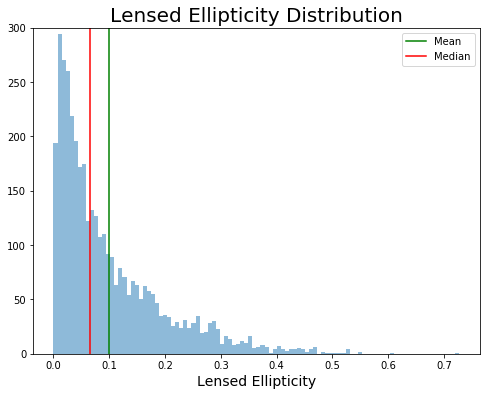

In [46]:
# let's plot the distribution

# create linear space for plotting the mean and median
y = np.linspace(-1, 1e5, 5)
x_mean = 0*y + np.mean(halo_lensed_e)
x_med = 0*y + np.median(halo_lensed_e)

print("The mean lensed ellipticity is", np.mean(halo_lensed_e))
print("The median lensed ellipticity is", np.median(halo_lensed_e))

plt.figure(figsize=(8,6))
plt.hist(halo_lensed_e, bins=100, alpha=0.5)
plt.plot(x_mean, y, 'g', label=r'Mean')
plt.plot(x_med, y, 'r', label=r'Median')
plt.legend(loc='best')
plt.xlabel(r'Lensed Ellipticity', fontsize=14)
#plt.xlim(-.04,1)
plt.ylim(0,300)
plt.title('Lensed Ellipticity Distribution', fontsize=20)
plt.show()

#### A Few Thoughts

How would we identify a cluster's BCG? 

The redMaPPer cluster catalog contains some quantities, such as `id_cen_0`, that might identify the central galaxies. We can these quantities with the following:
```python
# get the redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)
```
That being said, we also have `id_cen_1` through `id_cen_4`, so what would the difference between each of these be? Which (if any) would be the BCG?

If none of them, how else might we identify BCGs? Would it be the most massive member galaxy within some small radius of the center of the cluster? (The center's coordinates are given in the redMaPPer catalog, I believe.)

Note that it's likely that none of this can work until the issues with the methods for extracting member quantities with Dask have been addressed.

In [3]:
# get the redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in redM_quantities if 'member' not in q]
print("\nCluster quantities:\n")
print(cluster_quantities)

All redMaPPer quantities:

['theta_r_member', 'p_cen_0', 'dec_cen_1', 'magerr_g_lsst_member', 'mag_r_lsst_member', 'mag_i_lsst_member', 'redshift', 'ra', 'mag_z_lsst_member', 'magerr_y_lsst_member', 'magerr_r_lsst_member', 'ra_member', 'mag_g_lsst_member', 'p_member', 'richness', 'dec_cen_2', 'dec_cen_3', 'cluster_id_member', 'redshift_true_cg', 'magerr_i_lsst_member', 'pfree_member', 'refmag_err_member', 'theta_i_member', 'redshift_err', 'richness_err', 'scaleval', 'id_member', 'maskfrac', 'dec_cen_4', 'p_cen_1', 'id_cen_4', 'cluster_id', 'magerr_z_lsst_member', 'redshift_true_member', 'ra_cen_2', 'ra_cen_0', 'id_cen_3', 'id_cen_2', 'p_cen_4', 'dec_cen_0', 'dec_member', 'id_cen_0', 'ra_cen_3', 'mag_y_lsst_member', 'p_cen_2', 'p_cen_3', 'ra_cen_1', 'refmag_member', 'dec', 'ra_cen_4', 'id_cen_1']

Cluster quantities:

['p_cen_0', 'dec_cen_1', 'redshift', 'ra', 'richness', 'dec_cen_2', 'dec_cen_3', 'redshift_true_cg', 'redshift_err', 'richness_err', 'scaleval', 'maskfrac', 'dec_cen_4', '